## Imports and Some Settings

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
import pandas as pd
import math
import pickle
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True))
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 980, pci bus id: 0000:26:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## The Original Datasets: Load, Normalize

In [2]:
# load from files
raw_original_test_labels = idx2numpy.convert_from_file('datasets/fashion_mnist_test_labels.idx')
raw_original_test_data = idx2numpy.convert_from_file('datasets/fashion_mnist_test_data.idx')
raw_original_train_labels = idx2numpy.convert_from_file('datasets/fashion_mnist_train_labels.idx')
raw_original_train_data = idx2numpy.convert_from_file('datasets/fashion_mnist_train_data.idx')

# normalization
y_test = np.asarray(raw_original_test_labels, dtype=np.int32)
X_test = np.asarray(raw_original_test_data / 255.0, dtype=np.float32).reshape(-1, 28, 28, 1)
y_train = np.asarray(raw_original_train_labels, dtype=np.int32)
X_train = np.asarray(raw_original_train_data / 255.0, dtype=np.float32).reshape(-1, 28, 28, 1)
y_val = y_train[45000:]
X_val = X_train[45000:]
y_train = y_train[:45000]
X_train = X_train[:45000]

# just in case
IMG_SHAPE = (28,28,1)

## The Original Datasets: Display Some Images

In [3]:
def display_first_16_images(data):
    fig = plt.figure(figsize=(13, 13))
    axes=[]
    for ii in range(16):
        axes.append(fig.add_subplot(4, 4, ii + 1) )
        plt.imshow(data[ii].reshape((28,28)))
    plt.tight_layout()
    plt.gray()

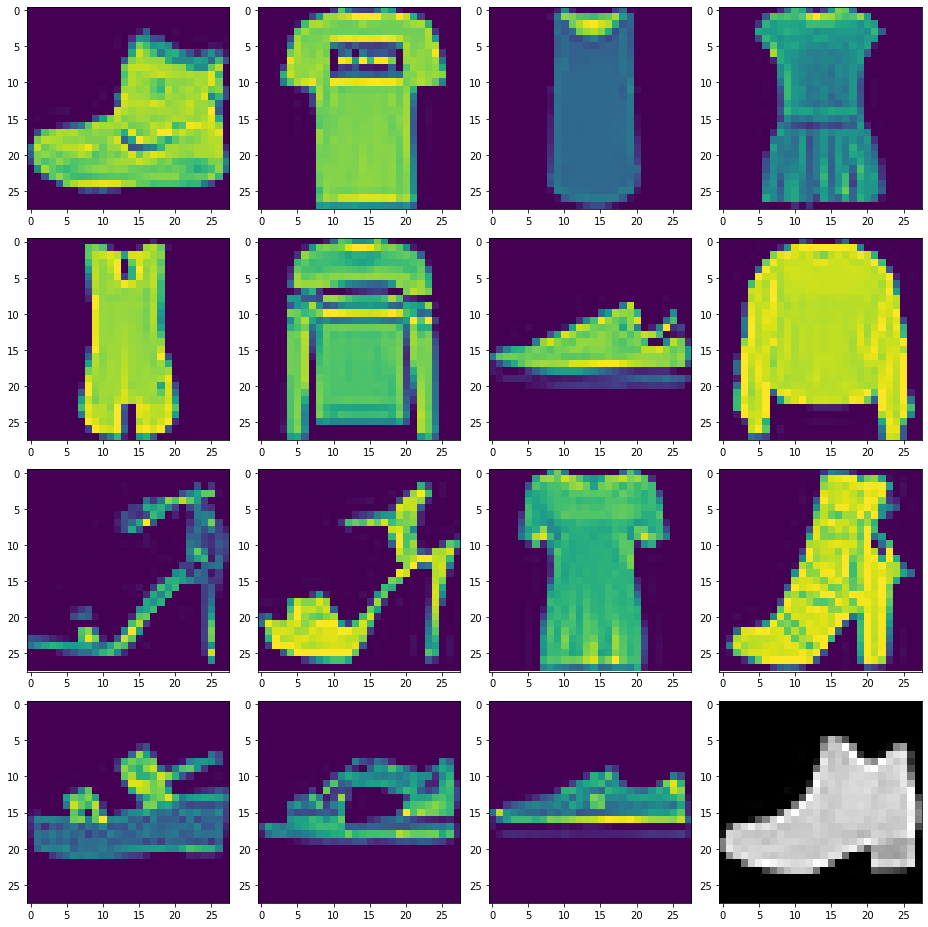

In [4]:
display_first_16_images(X_train)

## Augmentation Generators: Lukas's And Another Generators

In [5]:
lukas_augmentation = ImageDataGenerator(
    rotation_range=5, 
    horizontal_flip=True, 
    vertical_flip=True, 
    zoom_range=0.1)

In [6]:
another_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=(0.9, 1.1),
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='constant',
    cval=0)

In [7]:
def fit_aug_gen(data, aug_gen):
    aug_gen.fit(data)
    return aug_gen

## Lukas's Augmentation Generator: Display Some of Images

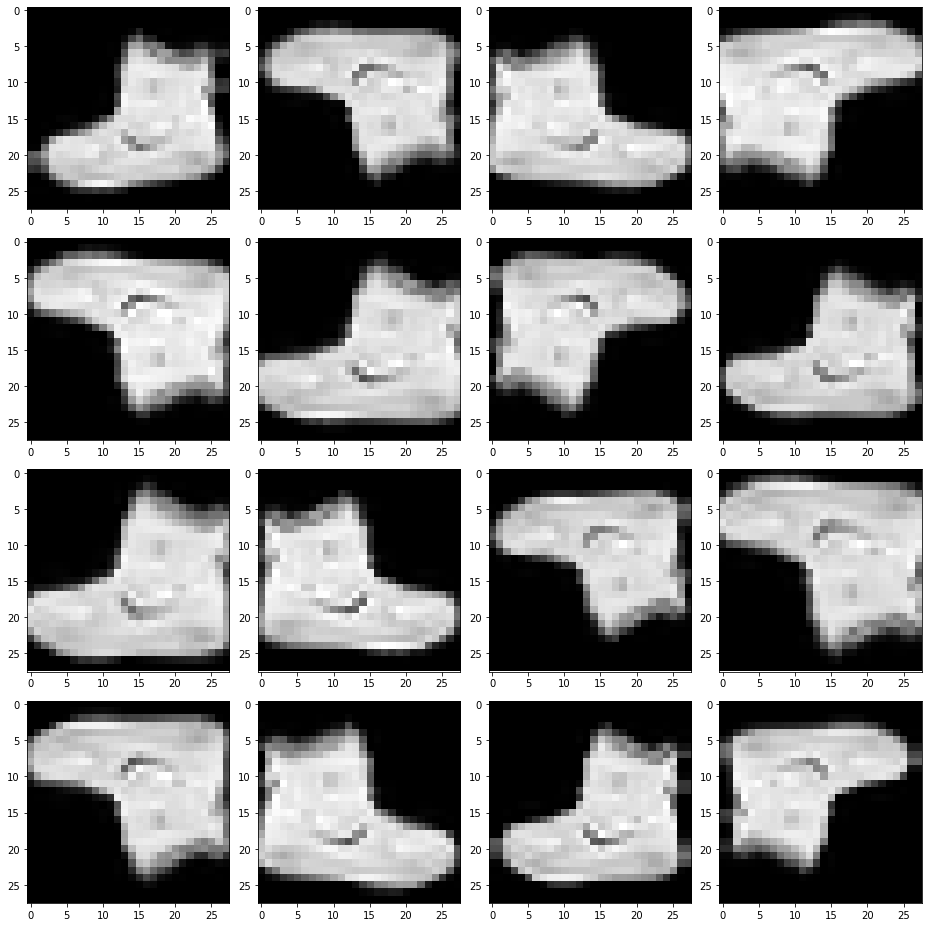

In [10]:
augmented_imgs = []
ii = 0
for batch in lukas_augmentation.flow(X_train[0].reshape((1,28,28,1))):
    augmented_imgs.append(batch[0].reshape((28,28)))
    ii += 1
    if ii > 16:
        break
display_first_16_images(augmented_imgs)

## Create Lukas's Models

In [11]:
lukas_model_1 = keras.Sequential([
    Conv2D(32, (3, 3), input_shape=IMG_SHAPE, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), input_shape=IMG_SHAPE, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

lukas_model_1.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

In [12]:
lukas_model_2 = keras.Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

lukas_model_2.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

In [13]:
lukas_model_3 = keras.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    Conv2D(256, 3, activation='relu', input_shape=IMG_SHAPE),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

lukas_model_3.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

## Simple Model

In [14]:
simple_model = keras.Sequential([
    keras.layers.Flatten(input_shape=IMG_SHAPE),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

simple_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

## Stolen Model:

In [15]:
mediums_model = keras.Sequential([
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=IMG_SHAPE),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    #Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    #MaxPooling2D(pool_size=2),
    #Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

mediums_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

## All Models: Training, Evaluating, Predicting

In [16]:
def train_and_test_model(model, epochs, batch_size, name, aug_gen=None, verbose=0):
    tensorboard = TensorBoard(log_dir="logs_fashion/{}".format(name))
    if aug_gen:
        history = model.fit(
            fit_aug_gen(X_train, aug_gen).flow(X_train, y_train, batch_size=batch_size),
            validation_data=(fit_aug_gen(X_val, aug_gen).flow(X_val, y_val, batch_size=batch_size)),
            steps_per_epoch=math.ceil(len(X_train) / batch_size), 
            epochs=epochs,
            validation_steps=math.ceil(len(X_val) / batch_size), 
            callbacks=[tensorboard],
            verbose=verbose)
    else:
        history = model.fit(
            X_train, 
            y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size, 
            callbacks=[tensorboard],
            verbose=verbose)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=verbose)
    return history, test_loss, test_acc

In [ ]:
_, loss_lukas_1, acc_lukas_1 = train_and_test_model(lukas_model_1, 10, 64, "lukas_1", lukas_augmentation, 1)

## Methods Displaying Loss, Accuracy And Prediction Loss&Accuracy

In [100]:
EPOCHS_STR = "Epo"
LOSS_STR = "Loss"
ACC_STR = "Acc"
T_LOSS_STR = " tr loss"
V_LOSS_STR = " val loss"
T_ACC_STR = " tr acc"
V_ACC_STR = " val acc"
T_LS = '-r'
V_LS = '-b'
def display_models_history(name, i):
    train_loss = pd.read_csv("logs_fashion/run-" + name + "_train-tag-epoch_loss.csv")
    val_loss = pd.read_csv("logs_fashion/run-" + name + "_validation-tag-epoch_loss.csv")
    train_acc = pd.read_csv("logs_fashion/run-" + name + "_train-tag-epoch_accuracy.csv")
    val_acc = pd.read_csv("logs_fashion/run-" + name + "_validation-tag-epoch_accuracy.csv")    
    sub = fig.add_subplot(1, 6, i)
    add_subplot(train_loss, sub, EPOCHS_STR, LOSS_STR, name + T_LOSS_STR,T_LS)
    add_subplot(val_loss, sub, EPOCHS_STR, LOSS_STR, name + V_LOSS_STR, V_LS)
    sub.grid()
    sub = fig.add_subplot(1, 6, i+1)
    add_subplot(train_acc, sub, EPOCHS_STR, ACC_STR, name + T_ACC_STR, T_LS)
    add_subplot(val_acc, sub, EPOCHS_STR, ACC_STR, name + V_ACC_STR, V_LS)
    sub.grid()
    
def add_subplot(dataset, sub, x_tittle, y_tittle, top_tittle, linestyle):
    x = dataset.values[:,1]
    y = dataset.values[:,2]
    sub.set_xlabel(x_tittle, fontsize=10)
    sub.set_ylabel(y_tittle, fontsize=10)
    sub.set_title(top_tittle)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    x_min = 0    
    x_max = np.max(x) + 1
    y_min = 0
    y_max = 1
    sub.set_xlim(x_min, x_max)
    sub.set_ylim(y_min, y_max)
    sub.plot(x, y, linestyle)

# Model Comparison:
    1. Lukas's Model 1    | Lukas's Augmentation | batch size = 64 | epochs = 150
    2. Lukas's Model 2    | Lukas's Augmentation | batch size = 64 | epochs = 120
    3. Lukas's Model 3    | Lukas's Augmentation | batch size = 32 | epochs = 15
    4. Simple Model       | Lukas's Augmentation | batch size = 64 | epochs = ?
    5. Medium's Model     | Lukas's Augmentation | batch size = 64 | epochs = ?
    
    6. Lukas's Model 1    | Another Augmentation | batch size = 64 | epochs = 150
    7. Lukas's Model 2    | Another Augmentation | batch size = 64 | epochs = 120
    8. Lukas's Model 3    | Another Augmentation | batch size = 32 | epochs = 15
    9. Simple Model       | Another Augmentation | batch size = 64 | epochs = ?
    10. Medium's Model    | Another Augmentation | batch size = 64 | epochs = ?
    
    11. Lukas's Model 1   | Original Data        | batch size = 64 | epochs = 150
    12. Lukas's Model 2   | Original Data        | batch size = 64 | epochs = 120
    13. Lukas's Model 3   | Original Data        | batch size = 32 | epochs = 15
    14. Simple Model      | Original Data        | batch size = 64 | epochs = ?
    15. Medium's Model    | Original Data        | batch size = 64 | epochs = ?

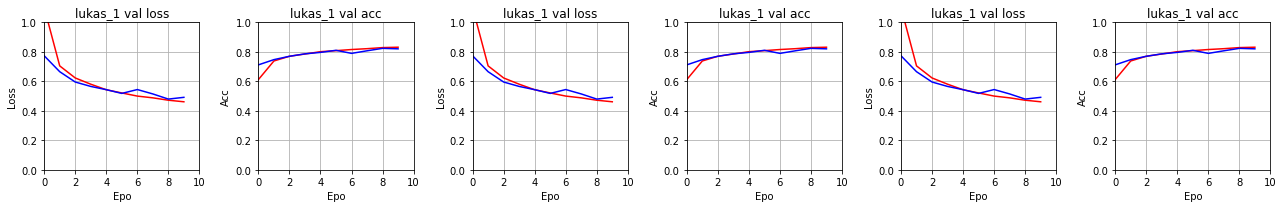

In [107]:
fig = plt.figure(figsize=(18, 3))
display_models_history("lukas_1",1)
display_models_history("lukas_1",3)
display_models_history("lukas_1",5)
plt.tight_layout()
plt.draw()